this notebook performs analysis of genome-wide and core-genes perturb-seq screen for the 3 datasets generated in Replogle et al. study. 

data obtained from: ## https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.patches as mpatches
import pickle
from scipy import stats
import gseapy as gp
from collections import defaultdict

In [3]:
# read in secrecon genesets and process map, as used in secseq plasma cell analysis vignette
## available for download in Synapse https://doi.org/10.7303/syn64026567

with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/gene_dict.pkl','rb') as f:
    gene_dict = pickle.load(f)
len([*gene_dict]),[*gene_dict][:5]

# import secrecon genesets
with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/t2g_dict.pickle','rb') as f:
    t2g_dict = pickle.load(f)

    
# import secRecon ontology mappings
with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/ont_c2p.pickle','rb') as f:
    ont_c2p = pickle.load(f)

with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/ont_c2p_2.pickle','rb') as f:
    ont_c2p_2 = pickle.load(f)

In [4]:
# create list of secRecon processes
sr_sys = {
    'systems': [],
    'subsystems': [],
    'processes': [],
    'subprocesses': []
}

# Populate the extracted dictionary
for key, values in gene_dict.items():
    for category in sr_sys.keys():
        sr_sys[category].extend(values.get(category, []))

# Ensure all values are unique
sr_sys = {k: list(set(v)) for k, v in sr_sys.items()}

sr_sys

{'systems': ['Translocation',
  'Proteostasis',
  'Vesicle trafficking',
  'Post-translational modifications',
  'Protein conformation'],
 'subsystems': ['Protein folding',
  'Mislocalized protein degradation',
  'Pre-Golgi',
  'Cytoskeletal remodeling',
  'Co-translational translocation',
  'Apoptosis',
  'Lipidation',
  'Carboxylation',
  'Post-translational translocation',
  'Acetylation',
  'Glycosylation',
  'Targeting to correct compartment/cargo sorting',
  'Autophagy (Vesicle trafficking)',
  'Disulfide bond formation',
  'ER stress response/UPR',
  'Vesicle budding',
  'ER Ca Homeostasis',
  'ERAD',
  'Membrane fusion',
  'Autophagy (Proteostasis)',
  'Hydroxylysine',
  'Post-Golgi',
  'Phosphorylation',
  'O-sulfation',
  'Multimerization',
  'TRC pathway',
  'Golgi organization',
  'ERpQC',
  'Lysosomal degradation/Glyco-conjugate degradation',
  'MAPS'],
 'processes': ['O-glycan',
  'Endocytic recycling',
  'Golgi to ER (retrograde)',
  'SLC acetyl-CoA transporter',
  'Ubiq

In [6]:
# read in go-slim genesets
gobp = gp.read_gmt(path="/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/c5.go.bp.v2023.2.Hs.symbols.gmt")

with open('../data/go_slim_db_mod.pkl','rb') as f:
    goslim = pickle.load(f)
len([*goslim])

246

# read in data

In [6]:
# read in anndata from perturbseq study
## https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387

# store each experiment in dictionary
ad = {}
ad['k_g'] = sc.read_h5ad('../data/K562_gwps_normalized_bulk_01.h5ad') # 11258 perturbations
ad['k_es'] = sc.read_h5ad('../data/K562_essential_normalized_bulk_01.h5ad') # 2285 perturbations
ad['rpe'] = sc.read_h5ad('../data/rpe1_normalized_bulk_01.h5ad') # 2679 perturbations
ad

{'k_g': AnnData object with n_obs × n_vars = 11258 × 8248
     obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
     var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv',
 'k_es': AnnData object with n_obs × n_vars = 2285 × 8563
     obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
     var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv',
 'rpe': AnnData object with n_obs × n_vars = 267

In [7]:
def generate_unique(value):
    """Generates a unique value with a serial number."""
    if value in value_counts:
        value_counts[value] += 1
    else:
        value_counts[value] = 1
    return f"{value}_{value_counts[value]}" if value_counts[value] > 1 else value

In [8]:
# preprocess anndata

## add perturbed gene target in anndata.obs
for i in [*ad]:
    ad[i].obs['gene'] = [i.split('_')[1] for i in ad[i].obs.index.tolist()]

## generate unique id for duplicated pseudobulk targetgene perturbations
    
### find duplicated gene symbols (just for reference)
dupgenes = {}
for i in [*ad]:
    dupgenes[i] = ad[i].var['gene_name'][ad[i].var['gene_name'].duplicated()].values.tolist()
    print(set(dupgenes[i]) & set([*gene_dict]))
print(dupgenes)


### first save the ensemble id (original index) as col
for i in [*ad]:
    ad[i].var['ens'] = ad[i].var.index.tolist()
    
    # generate unique id for duplicated pseudobulk targetgene perturbations and for var metadata
    value_counts = {}
    ad[i].obs['gene_ind'] = ad[i].obs['gene'].apply(generate_unique)

    value_counts = {}
#     ad[i].var['gene_ind'] = ad[i].var['gene_name'].values.apply(generate_unique)
    
    # add secRecon system
    ad[i].obs['secrecon_system'] = [gene_dict[g]['systems'][0] if g in [*gene_dict] else None for g in ad[i].obs['gene']]

    
    # make the gene symbol (unique) as index
    ad[i].var['gene_name'] = ad[i].var['gene_name'].astype(str)
    ad[i].var.index = ad[i].var['gene_name']
    ad[i].var_names_make_unique(join='_')
    
ad[i].var

set()
set()
set()
{'k_g': ['TBCE', 'HSPA14'], 'k_es': ['TBCE', 'HSPA14'], 'rpe': ['HSPA14']}


gene_name       mean        std        cv  in_matrix      gini  \
gene_name                                                                  
NOC2L         NOC2L   0.925306   0.216197  0.233649       True  0.124345   
PLEKHN1     PLEKHN1   0.126289   0.059157  0.468425       True  0.250009   
HES4           HES4   0.680438   0.365879  0.537711       True  0.223568   
ISG15         ISG15   0.462525   0.235287  0.508702       True  0.224943   
AGRN           AGRN   0.368164   0.154146  0.418689       True  0.212531   
...             ...        ...        ...       ...        ...       ...   
MT-ND4L     MT-ND4L   3.700753   1.091458  0.294929       True  0.152265   
MT-ND4       MT-ND4  82.065681  19.408978  0.236505       True  0.125400   
MT-ND5       MT-ND5  24.636215   5.965447  0.242141       True  0.127631   
MT-ND6       MT-ND6   3.701308   1.252693  0.338446       True  0.138177   
MT-CYB       MT-CYB  97.152924  25.826433  0.265833       True  0.139148   

           clean_mean  clean_std  clean_cv              ens  
gene_name                                                    
NOC2L        0.985649   0.225734  0.229020  ENSG00000188976  
PLEKHN1      0.132876   0.063824  0.480323  ENSG00000187583  
HES4         0.729217   0.399879  0.548367  ENSG00000188290  
ISG15        0.500009   0.260917  0.521824  ENSG00000187608  
AGRN         0.379996   0.162956  0.428837  ENSG00000188157  
...               ...        ...       ...              ...  
MT-ND4L      3.710612   1.087930  0.293194  ENSG00000212907  
MT-ND4      81.838829  18.903275  0.230982  ENSG00000198886  
MT-ND5      24.750563   5.950906  0.240435  ENSG00000198786  
MT-ND6       3.453148   1.241829  0.359622  ENSG00000198695  
MT-CYB      95.895744  24.754992  0.258145  ENSG00000198727  

[8749 rows x 10 columns]

# filter for strong perturbations

In [9]:
# strong perturbation criteria
## at least 50 DEGs at sig p<0.05 by AD test following BH correction
## at least 30% target knockdown or was not detected
## at least 25 cells that passed quality filters

strong_thresh = {}
strong_thresh['anderson_darling_counts'] = 50 # no. DEGs identified by AD test at sig. BH-pval < 0.05
strong_thresh['num_cells_filtered'] = 25 # at least no. cells bearing genetic perturbation, after filtering to remove cells
strong_thresh['pct_expr'] = -0.3 # at least 30% target knockdown (negative value means decreased expr vs ctrl cells)

In [15]:
ad[i].obs['pct_expr'].max(),ad[i].obs['pct_expr'].min(), ad[i].obs['pct_expr'].mean(),ad[i].obs['pct_expr'].median()

(19.81590866420462, -1.0, -0.8290641505130175, -0.9120226765425403)

In [18]:
# subset each anndata for "strong" perturbation population ## about 1000-1500 perturbations

## k562 global: 2k strong perturbations; 14% secRecon coverage; 8% of perturbations

ad_strong = {}
for i in [*ad]:
    print(i)
    ad_strong[i] = ad[i][ad[i].obs.anderson_darling_counts >= strong_thresh['anderson_darling_counts'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.num_cells_filtered >= strong_thresh['num_cells_filtered'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.pct_expr <= strong_thresh['pct_expr'], :].copy()
    
    # coverage of secRecon genes in strong perturbation
    print('\t','coverage secRecon genes (n=1127) all perturbations (n=',ad[i].obs.shape[0],')')
    print('\t', len(set([*gene_dict]) & set(ad[i].obs['gene'])),'/1127',np.round(len(set([*gene_dict]) & set(ad[i].obs['gene']))/1127,3),
         np.round(len(set([*gene_dict]) & set(ad[i].obs['gene']))/ad[i].obs.shape[0],3),'\n')
    
    print('\t','coverage secRecon genes (n=1127) strong perturbations (n=',ad[i].obs.shape[0],')')
    print('\t', len(set([*gene_dict]) & set(ad_strong[i].obs['gene'])),'/1127',np.round(len(set([*gene_dict]) & set(ad_strong[i].obs['gene']))/1127,3),
         np.round(len(set([*gene_dict]) & set(ad_strong[i].obs['gene']))/ad_strong[i].obs.shape[0],3),'\n')
    
#     # generate unique id for duplicated pseudobulk targetgene perturbations
#     value_counts = {}
#     ad_strong[i].obs['gene_ind'] = ad_strong[i].obs['gene'].apply(generate_unique)

    print('\t',ad_strong[i].shape)

k_g
	 coverage secRecon genes (n=1127) all perturbations (n= 11258 )
	 806 /1127 0.715 0.072 

	 coverage secRecon genes (n=1127) strong perturbations (n= 11258 )
	 160 /1127 0.142 0.082 

	 (1946, 8248)
k_es
	 coverage secRecon genes (n=1127) all perturbations (n= 2285 )
	 206 /1127 0.183 0.09 

	 coverage secRecon genes (n=1127) strong perturbations (n= 2285 )
	 97 /1127 0.086 0.088 

	 (1099, 8563)
rpe
	 coverage secRecon genes (n=1127) all perturbations (n= 2679 )
	 224 /1127 0.199 0.084 

	 coverage secRecon genes (n=1127) strong perturbations (n= 2679 )
	 165 /1127 0.146 0.104 

	 (1591, 8749)


In [19]:
# set expression of perturbation target to 0

target_og_expr = defaultdict(list) # init list of original target expressions

# go through strong perturbations and set target gene expr to 0

for i in [*ad_strong]:
#     print(ad_strong[i].obs.shape)
    
    # for each gene target
    for ind, row in ad[i].obs.iterrows():
        
        # get gene
        g = row['gene']
        
        # if gene is strong perturbation and in measured transcriptome 
        if g in ad_strong[i].obs['gene'].tolist() and g in ad[i].var['gene_name'].to_list():
            # get cell id
            cell_idx = ad[i].obs_names.get_loc(ind)
            
            # get all gene matches and .var index
            g_ind = ad[i].var[ad[i].var['gene_name'] == g].index.tolist()
        
#             if len(g_ind) > 1:
#                 print(g_ind)

            for g_i in g_ind:
                gene_idx = ad[i].var_names.get_loc(g_i)
            
                target_og_expr[i].append(ad[i].X[cell_idx,gene_idx])
                
                # set expr to 0
                ad[i].X[cell_idx,gene_idx] = 0
        
        else:
            continue

# score genesets

In [23]:
# score secRecon and GO geneset expression
## geneset scoring needs to be done with control cells included since the ctrl genes/binning is across all single-cells 

hm_skip = [] # go genesets skipped
sr_skip = [] # secrecon genesets skipped

for i in [*ad]:
    # GO-BP terms
    for c in [*goslim]:
        if len(goslim[c]) > 5:
            try:
                sc.tl.score_genes(ad[i], goslim[c], score_name=c)
            except (KeyError, ValueError):
                hm_skip.append(c)
                continue
    
    # secrecon terms
    for c in [*t2g_dict]:
        if len(t2g_dict[c]) > 5:
            try:
                sc.tl.score_genes(ad[i], t2g_dict[c], score_name='SR_'+c)
            except (KeyError, ValueError):
                sr_skip.append(c)
#                 print('skipped',c)
                continue

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


In [7]:
# save anndata pkl
with open('../data/allscreens_go-secrecon-scored.pkl','wb') as f:
    pickle.dump(ad,f)
# with open('../data/allscreens_go-secrecon-scored.pkl','rb') as f:
#     ad = pickle.load(f)

In [10]:
# filter for strong perturbations again
# subset each anndata for "strong" perturbation population ## about 1000-1500 perturbations

## k562 global: 2k strong perturbations; 14% secRecon coverage; 8% of perturbations

ad_strong = {}
for i in [*ad]:
    print(i)
    ad_strong[i] = ad[i][ad[i].obs.anderson_darling_counts >= strong_thresh['anderson_darling_counts'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.num_cells_filtered >= strong_thresh['num_cells_filtered'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.pct_expr <= strong_thresh['pct_expr'], :].copy()

    print('\t',ad_strong[i].shape)

k_g
	 (1946, 8248)
k_es
	 (1099, 8563)
rpe
	 (1591, 8749)


In [11]:
# secRecon gene representation in transcriptome
for i in [*ad]:
    print(i)
    
    # coverage of secRecon genes in  transcriptome
    print('\t','coverage secRecon genes (n=1127) in measured transcriptome (n=',ad_strong[i].obs.shape[0],')')
    print('\t', len(set([*gene_dict]) & set(ad_strong[i].obs['gene'])),'/1127',np.round(len(set([*gene_dict]) & set(ad_strong[i].obs['gene']))/1127,3),
         np.round(len(set([*gene_dict]) & set(ad_strong[i].var['gene_name']))/ad_strong[i].var.shape[0],3),'\n')
    

k_g
	 coverage secRecon genes (n=1127) in measured transcriptome (n= 1946 )
	 160 /1127 0.142 0.089 

k_es
	 coverage secRecon genes (n=1127) in measured transcriptome (n= 1099 )
	 97 /1127 0.086 0.088 

rpe
	 coverage secRecon genes (n=1127) in measured transcriptome (n= 1591 )
	 165 /1127 0.146 0.091 



In [12]:
# what is coverage of each system, subsystem, etc. in global screen
## all perturbations: 60-90% of systems
## strong perturbations: 10-40% of systems # PTM has lowest representation

for s in sr_sys['systems']:
    print(s)
    
    print('\t','coverage secRecon system for all perturbations (n=',ad['k_g'].obs.shape[0],')')
    print('\t', len(set(t2g_dict[s]) & set(ad['k_g'].obs['gene'])),'/',len(t2g_dict[s]),np.round(len(set(t2g_dict[s]) & set(ad['k_g'].obs['gene']))/len(t2g_dict[s]),3),
         np.round(len(set(t2g_dict[s]) & set(ad['k_g'].obs['gene']))/ad['k_g'].obs.shape[0],3),'\n')
    
for s in sr_sys['systems']:
    print(s)
    print('\t','coverage secRecon system for strong perturbations (n=',ad_strong['k_g'].obs.shape[0],')')
    print('\t', len(set(t2g_dict[s]) & set(ad_strong['k_g'].obs['gene'])),'/',len(t2g_dict[s]),np.round(len(set(t2g_dict[s]) & set(ad_strong['k_g'].obs['gene']))/len(t2g_dict[s]),3),
         np.round(len(set(t2g_dict[s]) & set(ad_strong['k_g'].obs['gene']))/ad_strong['k_g'].obs.shape[0],3),'\n')

Translocation
	 coverage secRecon system for all perturbations (n= 11258 )
	 46 / 49 0.939 0.004 

Proteostasis
	 coverage secRecon system for all perturbations (n= 11258 )
	 296 / 374 0.791 0.026 

Vesicle trafficking
	 coverage secRecon system for all perturbations (n= 11258 )
	 340 / 445 0.764 0.03 

Post-translational modifications
	 coverage secRecon system for all perturbations (n= 11258 )
	 206 / 343 0.601 0.018 

Protein conformation
	 coverage secRecon system for all perturbations (n= 11258 )
	 116 / 159 0.73 0.01 

Translocation
	 coverage secRecon system for strong perturbations (n= 1946 )
	 19 / 49 0.388 0.01 

Proteostasis
	 coverage secRecon system for strong perturbations (n= 1946 )
	 81 / 374 0.217 0.042 

Vesicle trafficking
	 coverage secRecon system for strong perturbations (n= 1946 )
	 57 / 445 0.128 0.029 

Post-translational modifications
	 coverage secRecon system for strong perturbations (n= 1946 )
	 33 / 343 0.096 0.017 

Protein conformation
	 coverage secReco

In [13]:
# get all 'features' columns
cols_feat = {}
for i in [*ad]:
#     cols_feat[i] = [c for c in ad[i].obs.columns if 'HALL' in c or 'SR_' in c]
    cols_feat[i] = [c for c in ad[i].obs.columns if 'GO:' in c or 'SR_' in c]

cols_feat[i]

['GO:0000278_mitotic.cell.cycle',
 'GO:0002181_cytoplasmic.translation',
 'GO:0002376_immune.system.process',
 'GO:0003014_renal.system.process',
 'GO:0003016_respiratory.system.process',
 'GO:0005975_carbohydrate.metabolic.process',
 'GO:0006091_generation.of.precursor.metabolites.and.energy',
 'GO:0006260_DNA.replication',
 'GO:0006281_DNA.repair',
 'GO:0006310_DNA.recombination',
 'GO:0006325_chromatin.organization',
 'GO:0006351_DNA-templated.transcription',
 'GO:0006355_regulation.of.DNA-templated.transcription',
 'GO:0006457_protein.folding',
 'GO:0006486_protein.glycosylation',
 'GO:0006520_amino.acid.metabolic.process',
 'GO:0006629_lipid.metabolic.process',
 'GO:0006790_sulfur.compound.metabolic.process',
 'GO:0006886_intracellular.protein.transport',
 'GO:0006913_nucleocytoplasmic.transport',
 'GO:0006914_autophagy',
 'GO:0007005_mitochondrion.organization',
 'GO:0007018_microtubule-based.movement',
 'GO:0007031_peroxisome.organization',
 'GO:0007040_lysosome.organization',
 

# cluster perturbations with respect to GO/secRecon pathway scores

Q: What perturbations cluster together w.r.t. phenotype, represented by pathway scores? identifying clusters of genes with similar functions/roles

Expectations:

1. secRecon genes to cluster together, confirming functional effects and annotations
2. other genes outside of secRecon to cluster with secRecon genes -- possible indirect/direct interactions -- are they enriched for PPI?
3. pathway level clustering -- what pathways/genesets may be co-regulated, similar GO/secRecon terms

In [14]:
def clustermap_with_colored_labels(data, labels_to_color, color='red',size=(10,8),title='',remove_dend=False):
    """
    Create a Seaborn clustermap with column labels colored if they are in a specified list.
    
    Args:
        data (pd.DataFrame): Input data for the clustermap.
        labels_to_color (list): List of column labels to color.
        color (str): Color to use for the specified labels.
    
    Returns:
        sns.matrix.ClusterGrid: The resulting clustermap object.
    """
    # Create a color mapping: Red for selected, Grey otherwise
    col_colors = ["red" if col.split('_')[0] in [*gene_dict] else "grey" for col in data.columns]

    # Convert to DataFrame (Seaborn requires DataFrame format)
    col_colors_df = pd.DataFrame(col_colors, index=data.columns, columns=["secRecon=red"])
    
    # Create the clustermap ## scale color by columns (transpose for each cell/sample)
    if remove_dend:
        cluster = sns.clustermap(data,z_score=0, metric='correlation',cmap="vlag", figsize=size,center=0,vmax=3,vmin=-3,dendrogram_ratio=(0, 0),
                                 col_colors=col_colors_df)
    else:
        cluster = sns.clustermap(data,z_score=0, metric='correlation',cmap="vlag", figsize=size,center=0,vmax=3,vmin=-3,
                                col_colors=col_colors_df)
    
    # Get the current plot
    ax = cluster.ax_heatmap
    
    # Customize column labels
    for label in ax.get_xticklabels():
        if label.get_text().split('_')[0] in labels_to_color:
            label.set_color(color)
            
        for label in ax.get_yticklabels():
            if label.get_text().split('_')[0] =='SR':
                label.set_color(color)
    
    ax.set(xlabel='perturbation (secRecon=red)', ylabel='geneset score')
    
    plt.title(title)
    
    if remove_dend:
        ax.ax_row_dendrogram.set_visible(False)
        ax.ax_col_dendrogram.set_visible(False)
    
    plt.show()
    return cluster

In [1]:
# get df for clustering, visualizations
### all = all genesets

ad_strong_viz = defaultdict(dict)
for i in [*ad_strong]:
    ad_strong_viz[i]['all'] = ad_strong[i].obs.copy()
    ad_strong_viz[i]['all'].index = ad_strong_viz[i]['all']['gene_ind']
    ad_strong_viz[i]['all'] = ad_strong_viz[i]['all'][[c for c in ad_strong_viz[i]['all'].columns if 'GO:' in c or 'SR_' in c]]
    ad_strong_viz[i]['GO'] = ad_strong_viz[i]['all'][[c for c in ad_strong_viz[i]['all'].columns if 'GO:' in c]].copy()
    ad_strong_viz[i]['secRecon'] = ad_strong_viz[i]['all'][[c for c in ad_strong_viz[i]['all'].columns if 'SR_' in c]].copy()

# ad_strong_viz[i]

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


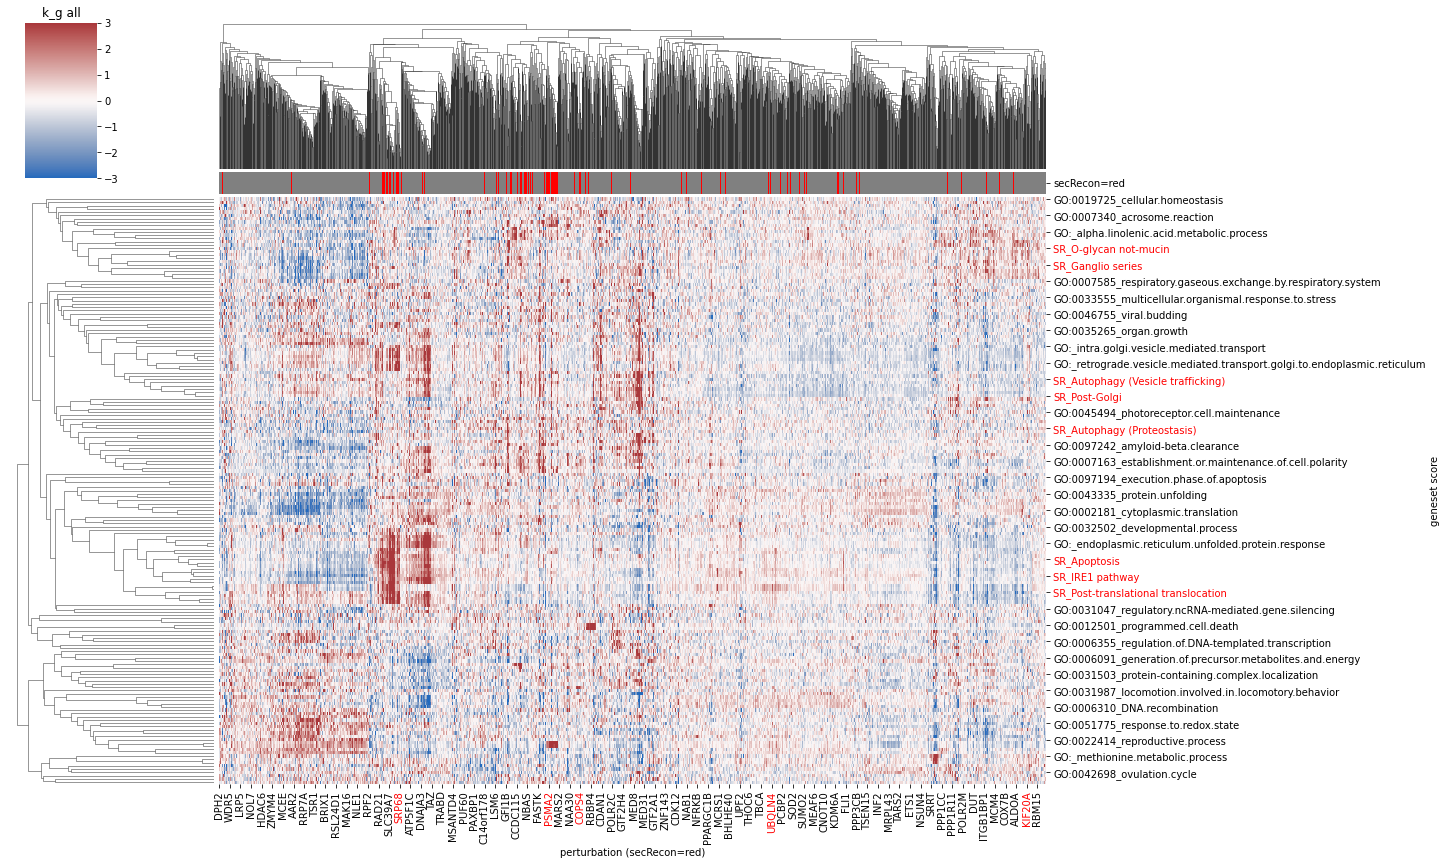

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


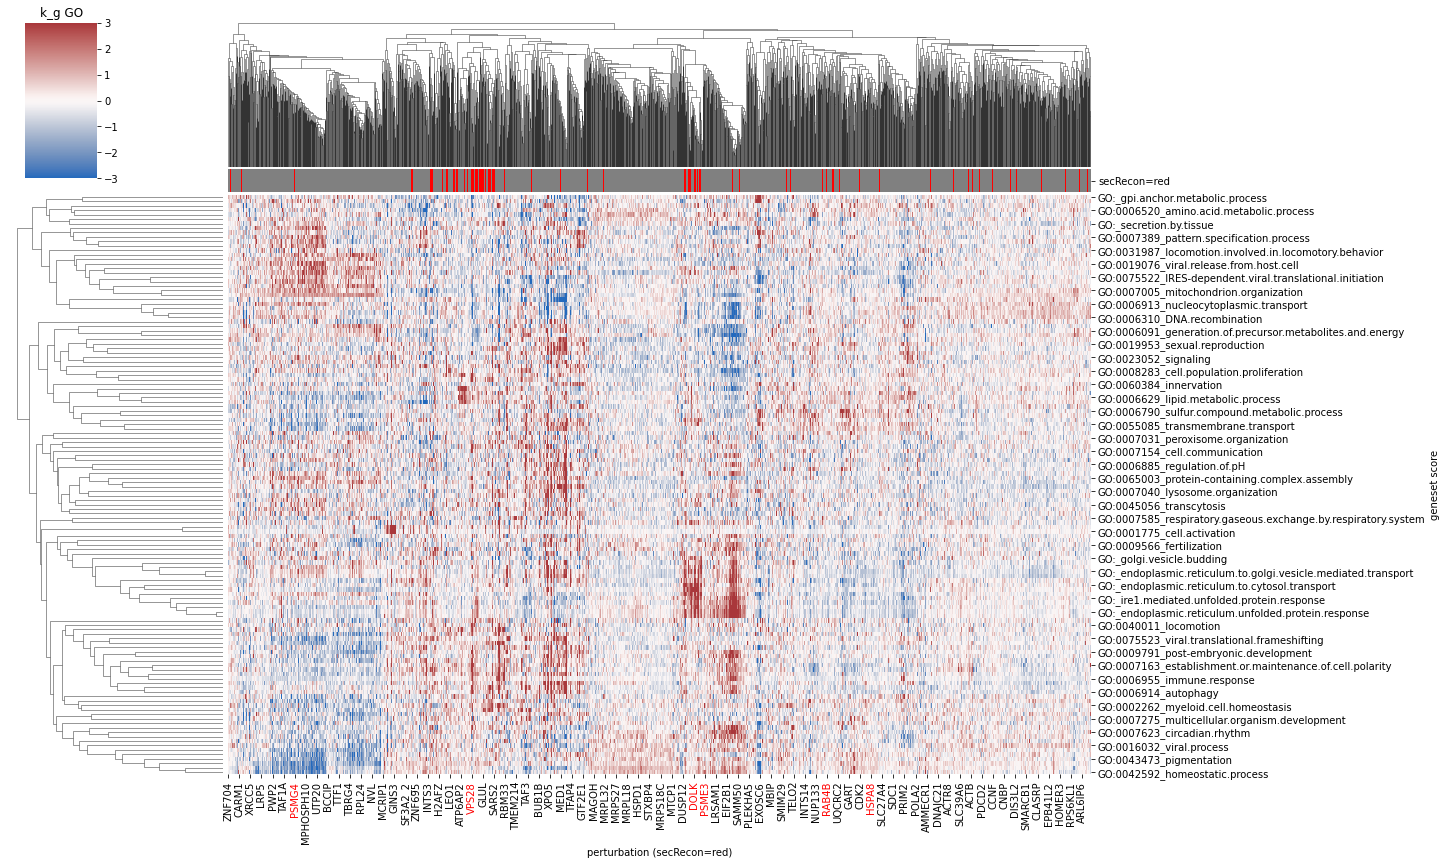

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


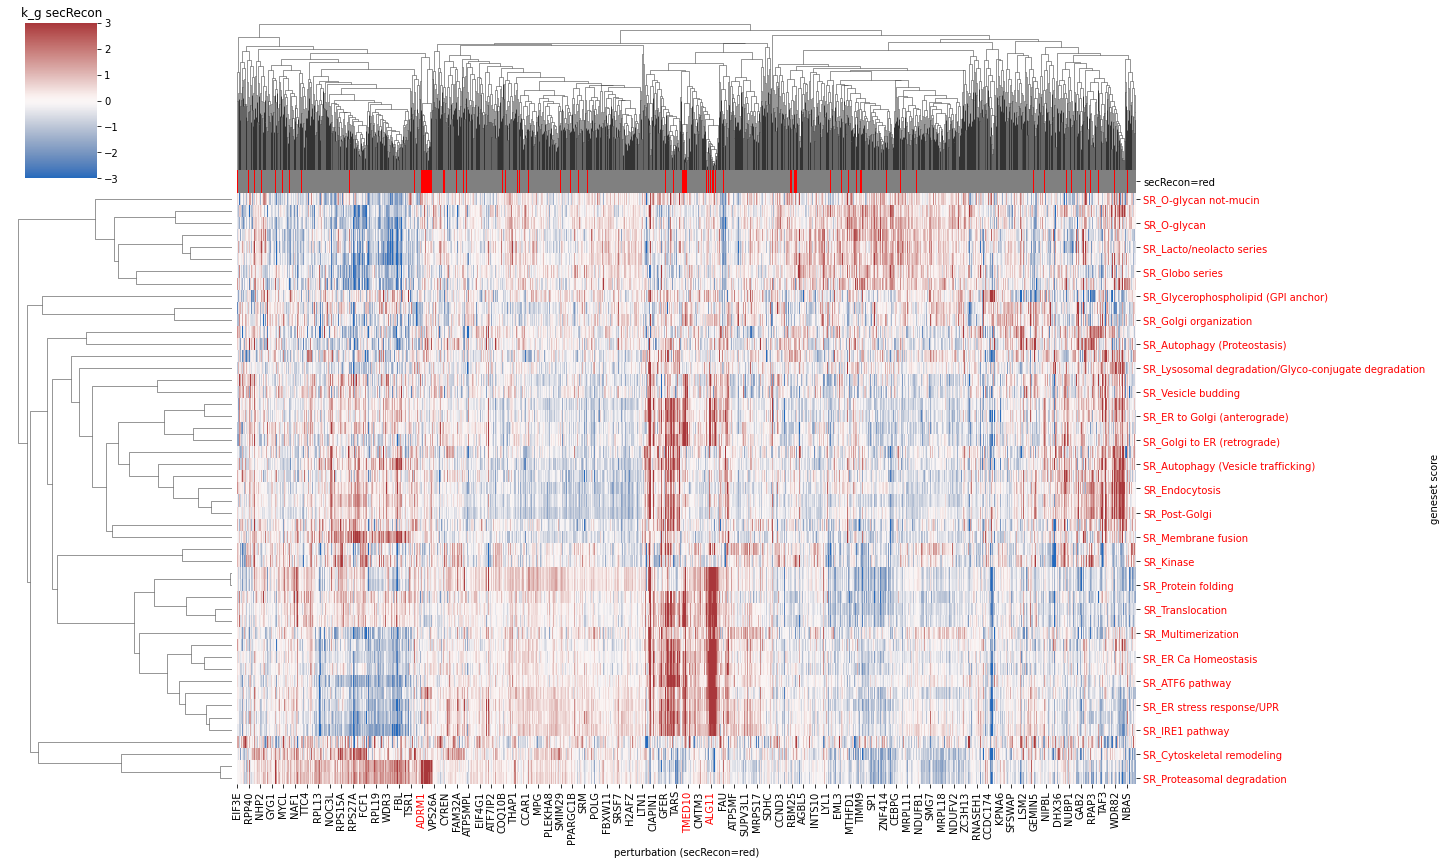

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


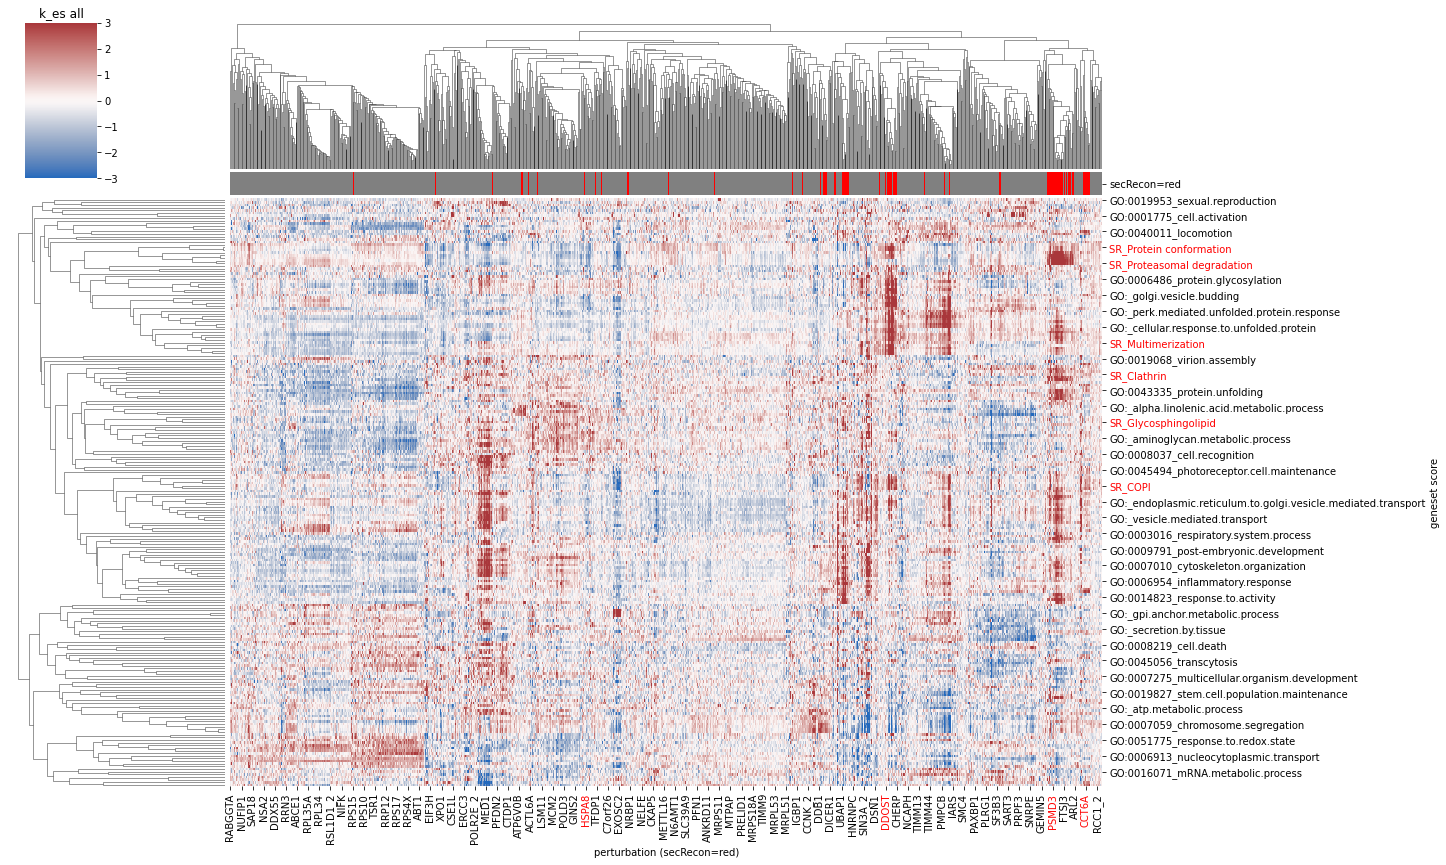

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


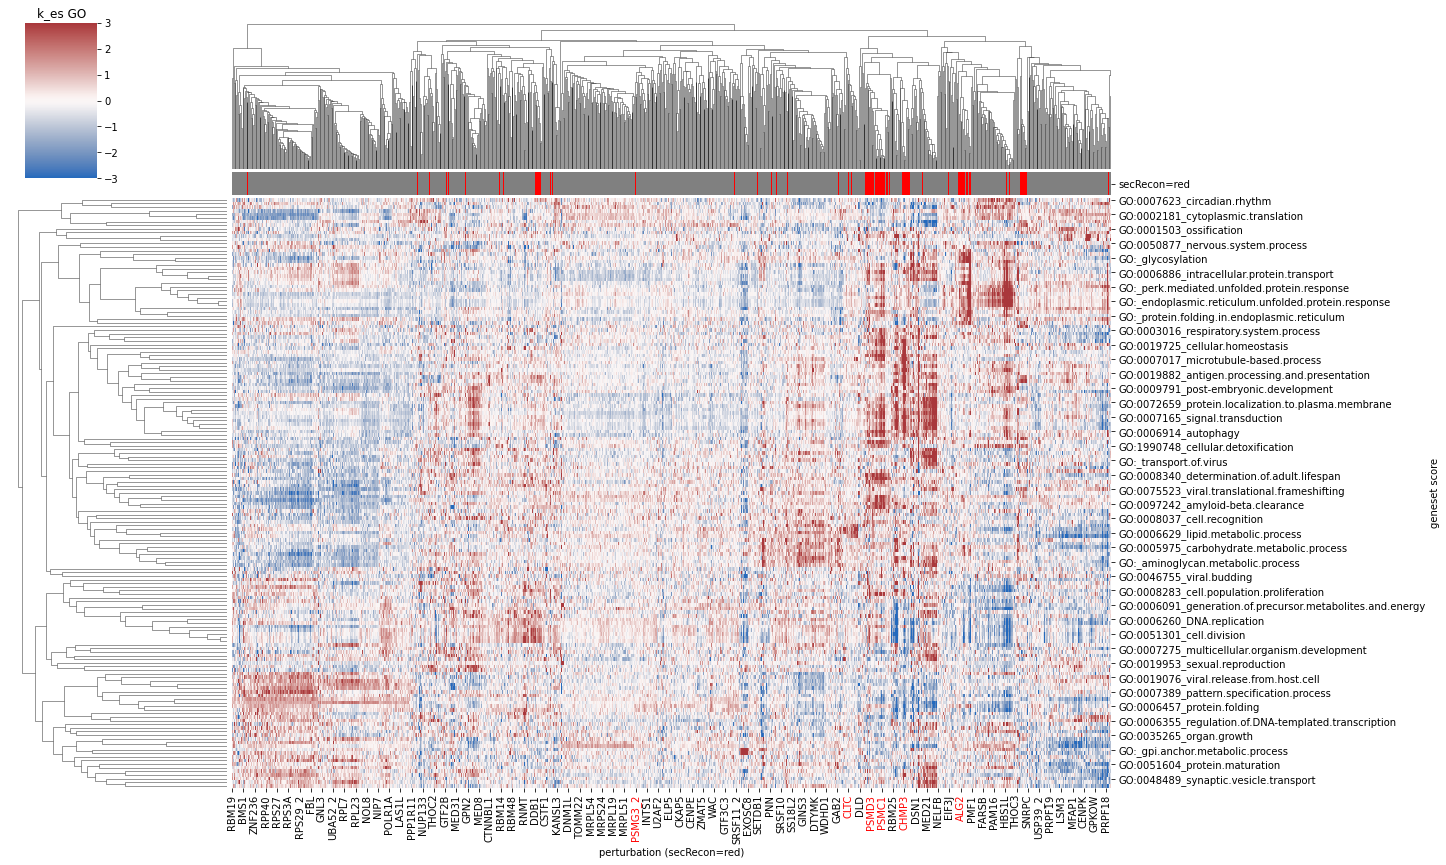

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


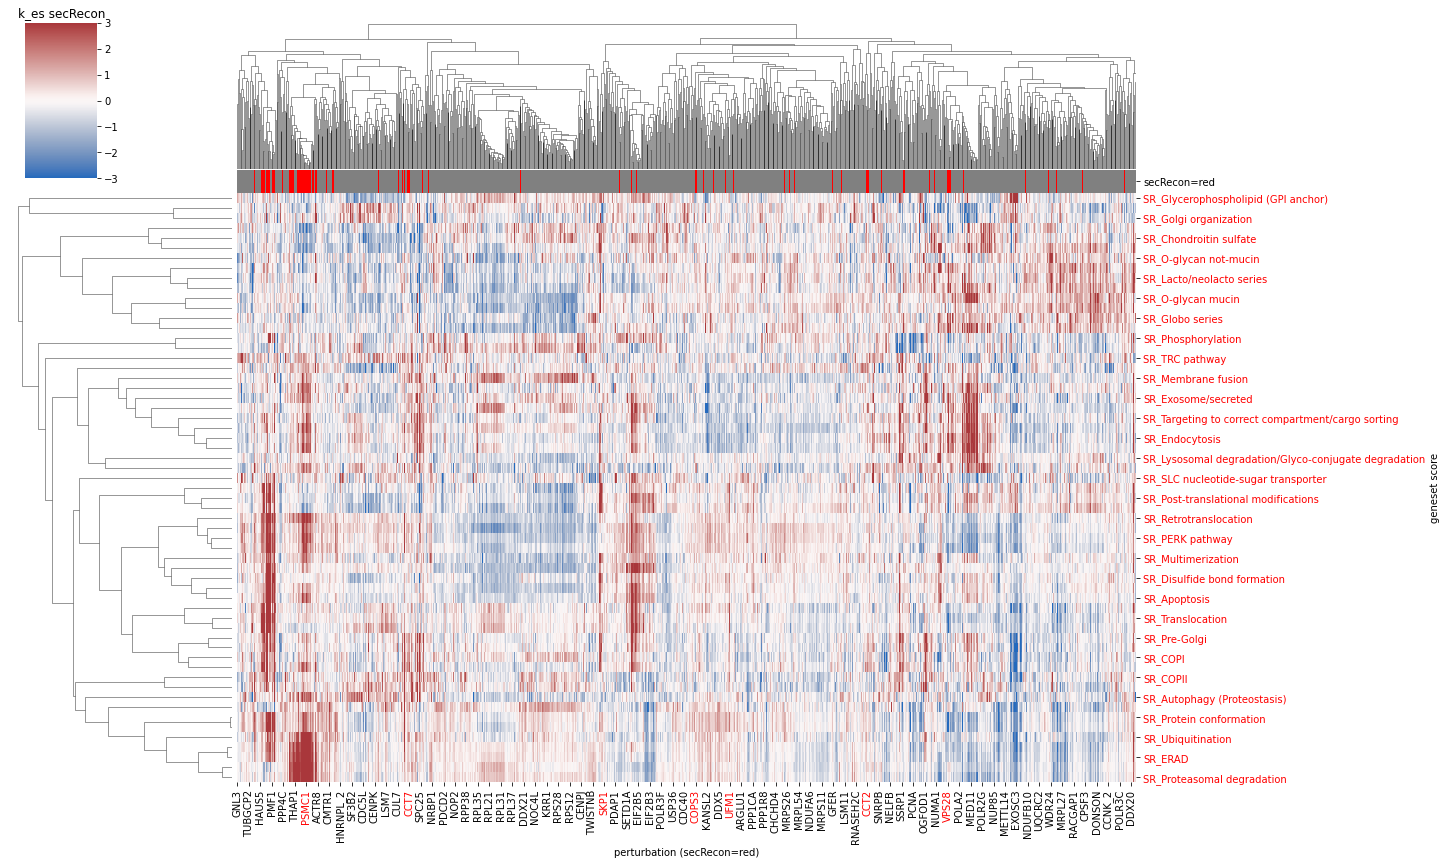

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


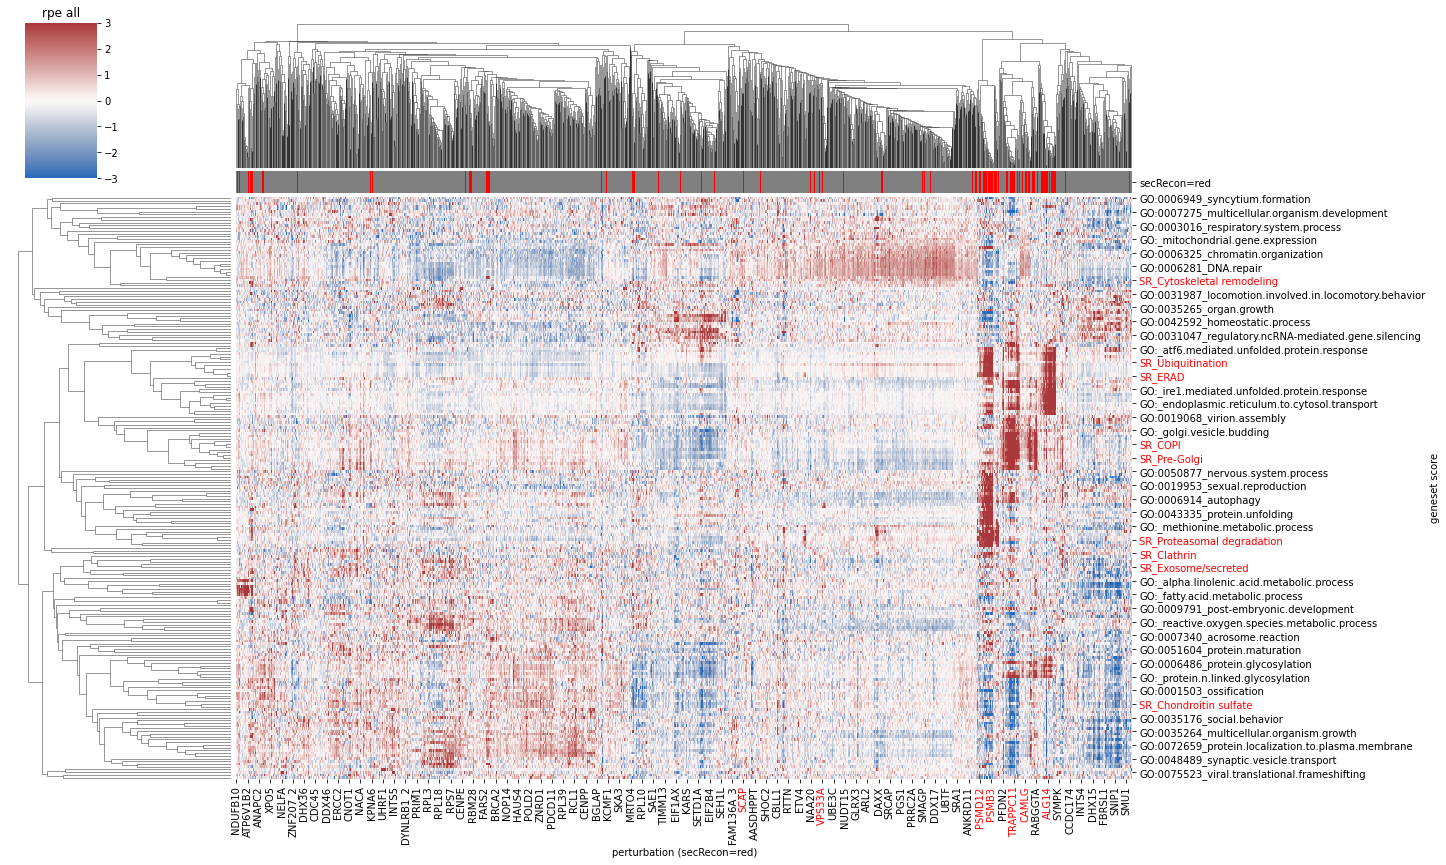

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


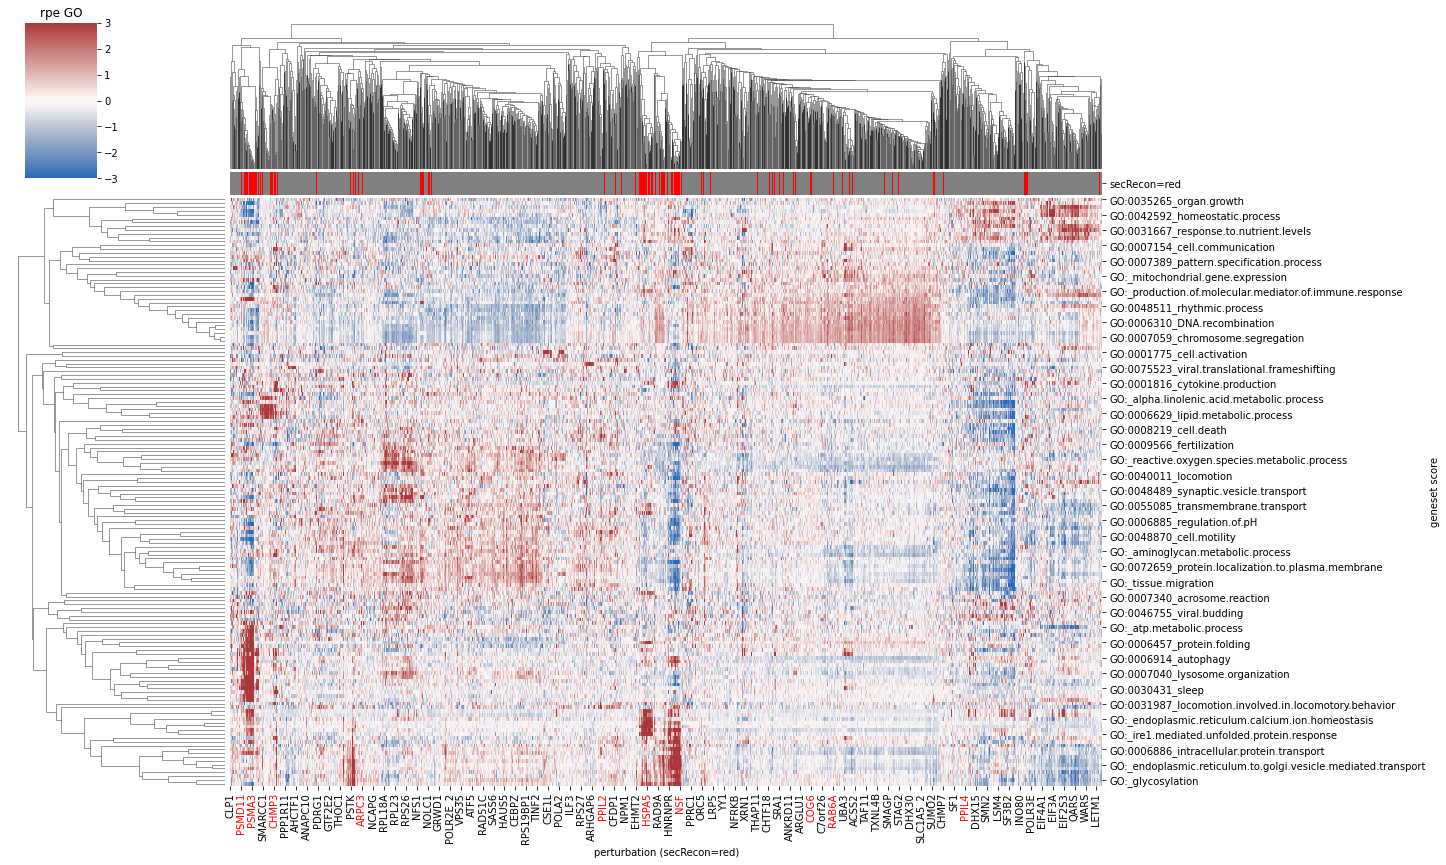

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


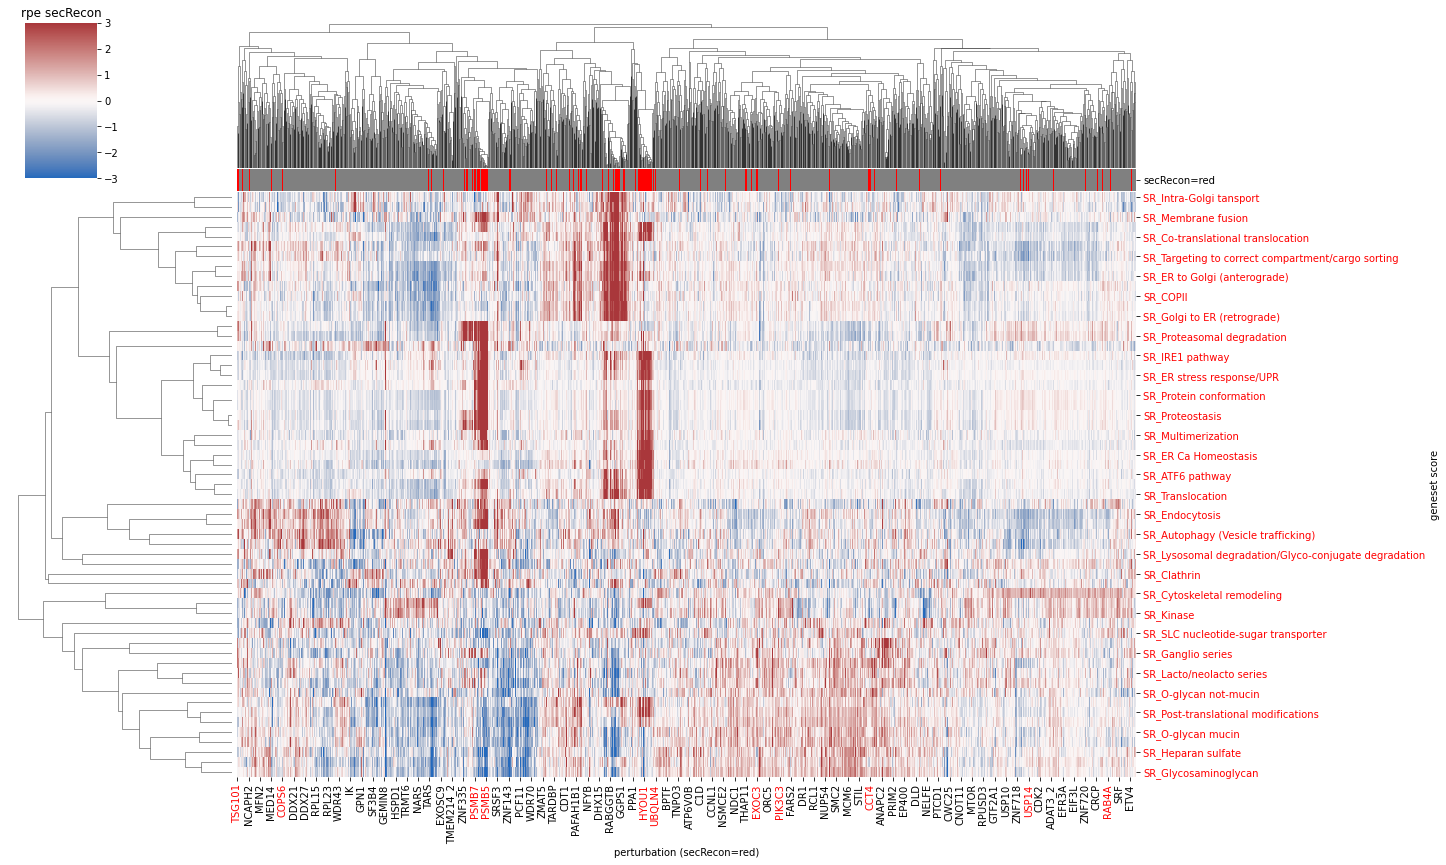

In [384]:
# plot/cluster perturbations against pathway score
## filter for strong perturbations

# init a dictionary to store the linkage matrix from each clustermap -- for clustering and dendrograms downstream
ad_strong_viz_dend = defaultdict(dict)

for i in [*ad_strong_viz]:
    for db in [*ad_strong_viz[i]]:
        i_c = clustermap_with_colored_labels(ad_strong_viz[i][db].T, [*gene_dict], color='red',size=(20,12),title=i+' '+db,remove_dend=False)
        ad_strong_viz_dend[i][db+'_perturbation'] = i_c.dendrogram_col.linkage
        ad_strong_viz_dend[i][db+'_pathway'] = i_c.dendrogram_row.linkage

In [59]:
from scipy.cluster.hierarchy import fcluster,linkage, dendrogram

def kclusters_elbowplot(linkagemat,data,samplenames,dendsize=(20,5),elbowsize=(10,5),ptitle='',max_k=90):
    i_dend = dendrogram(linkagemat,labels=None,leaf_rotation=90,no_plot=False) # labels=samplenames

    # Compute the Elbow Plot
    max_clusters = max_k
    wcss = []

    for k in range(2, max_clusters + 2,2):
        # Get cluster assignments
        cluster_labels = fcluster(linkagemat, k, criterion="maxclust")

        # Compute WCSS
        cluster_wcss = 0
        for cluster in np.unique(cluster_labels):
            cluster_points = data.values[:,cluster_labels == cluster]
            cluster_center = cluster_points.mean(axis=1, keepdims=True)
            cluster_wcss += np.sum((cluster_points - cluster_center) ** 2)
        wcss.append(cluster_wcss)

    # Plot elbow curve
    plt.figure(figsize=elbowsize)
    plt.plot(range(2, max_clusters + 2,2), wcss, marker='o', linestyle='-')
    plt.title(ptitle+" | Elbow Plot for k Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.xticks(range(2, max_clusters + 2,4))
    plt.grid()
    plt.show()
    
#     return wcss

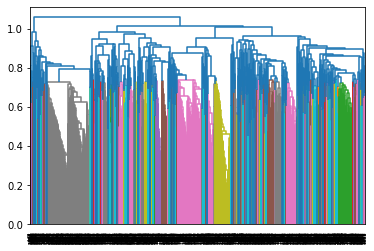

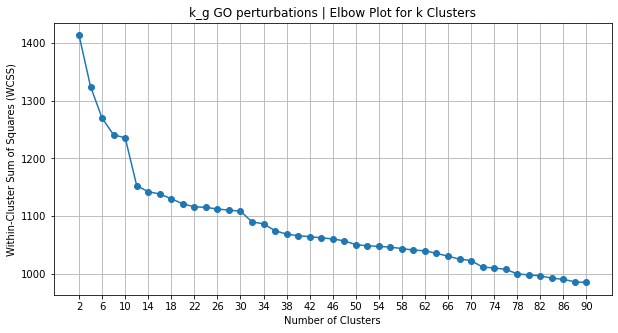

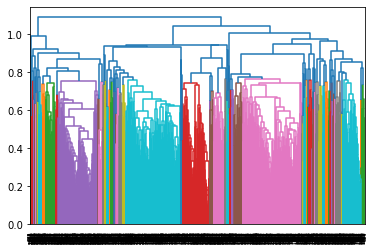

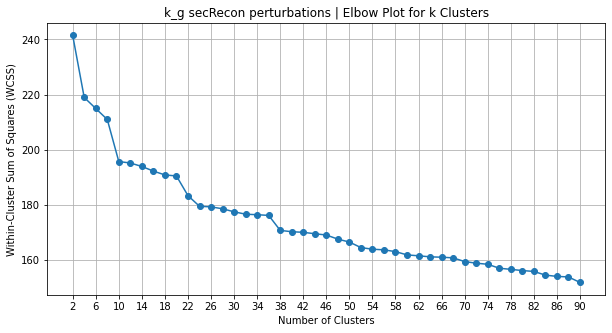

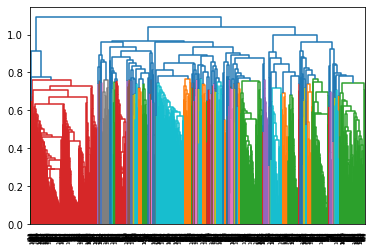

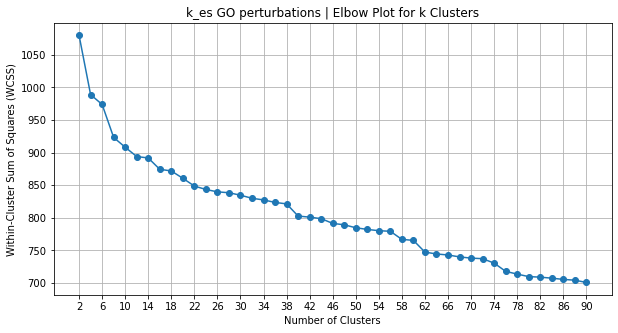

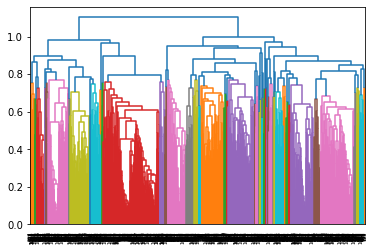

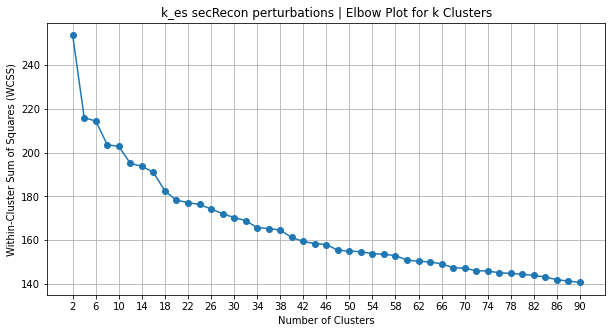

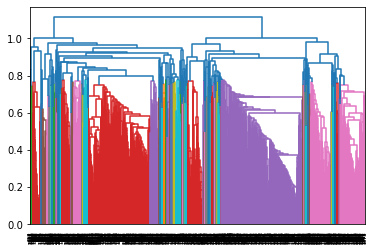

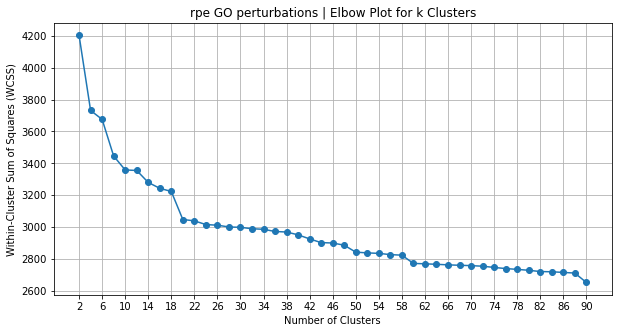

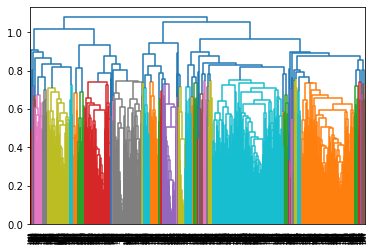

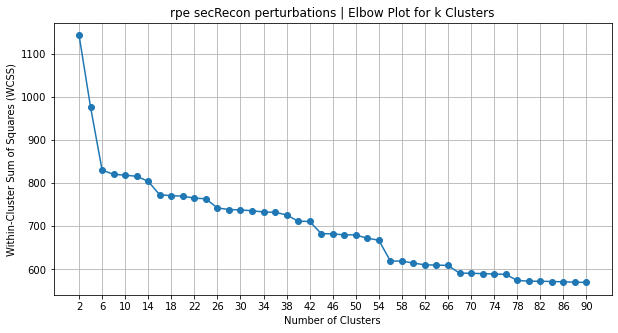

In [60]:
# generate elbow plots to choose k clusters that balances number_of_genes per cluster and intra-cluster vs inter strength
for i in [*ad]:
    for db in ['GO','secRecon']:
        kclusters_elbowplot(ad_strong_viz_dend[i][db+'_perturbation'],ad_strong_viz[i][db].T,ad_strong_viz[i][db].index.tolist(),
                       ptitle=i + ' ' + db + ' ' +'perturbations')

In [70]:
# using selected k, generate the clusters

ad_strong_viz_dend['k_g']['GO_perturbation-kclusters'] = 32
ad_strong_viz_dend['k_g']['secRecon_perturbation-kclusters'] = 38
ad_strong_viz_dend['k_es']['GO_perturbation-kclusters'] = 40
ad_strong_viz_dend['k_es']['secRecon_perturbation-kclusters'] = 40
ad_strong_viz_dend['rpe']['GO_perturbation-kclusters'] = 42
ad_strong_viz_dend['rpe']['secRecon_perturbation-kclusters'] = 44

In [62]:
# extract ids for each k cluster 

def extract_clusters(linkage_matrix, k, sample_ids):
    """
    Extract a dictionary of cluster IDs and their associated sample IDs.
    
    Args:
        linkage_matrix: Linkage matrix from hierarchical clustering.
        k: Number of clusters.
        sample_ids: List of sample IDs corresponding to the rows/columns of the correlation matrix.
    
    Returns:
        dict: Dictionary with cluster IDs as keys and lists of sample IDs as values.
    """
    # Generate cluster labels
    cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')
    
    # Create dictionary mapping cluster IDs to sample IDs
    clusters = {}
    for cluster_id in np.unique(cluster_labels):
        clusters[cluster_id] = [sample_ids[i] for i in range(len(sample_ids)) if cluster_labels[i] == cluster_id]
    
    # return cluster:[genes] and gene:cluster dictionary maps
    clusters_inv = {sample: cluster for cluster, samples in clusters.items() for sample in samples}

    return clusters, clusters_inv

In [71]:
# obtain perturbations per identified cluster
for i in [*ad_strong_viz_dend]:
    for x in [*ad_strong_viz_dend[i]]:
        if 'perturbation-kclusters' in x:
            db = x.split('_')[0]
            ad_strong_viz_dend[i][db+'_perturbation_kclustermaps']= extract_clusters(ad_strong_viz_dend[i][db+'_perturbation'],
                                             ad_strong_viz_dend[i][x],
                                             ad_strong_viz[i][db].index.tolist())
            print(i,db)
            for key, value in ad_strong_viz_dend[i][db+'_perturbation_kclustermaps'][0].items():
                print(f"{key}: {len(value)} \t sr {len([g for g in value if g in [*gene_dict]])} \t |  sr_trans {len([g for g in value if g in t2g_dict['Translocation']])} \t |  sr_prot {len([g for g in value if g in t2g_dict['Proteostasis']])}")

k_g GO
1: 16 	 sr 2 	 |  sr_trans 0 	 |  sr_prot 1
2: 7 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
3: 4 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
4: 326 	 sr 5 	 |  sr_trans 0 	 |  sr_prot 3
5: 25 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 0
6: 6 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
7: 81 	 sr 9 	 |  sr_trans 0 	 |  sr_prot 7
8: 21 	 sr 3 	 |  sr_trans 0 	 |  sr_prot 2
9: 2 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
10: 28 	 sr 9 	 |  sr_trans 1 	 |  sr_prot 6
11: 2 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 0
12: 106 	 sr 43 	 |  sr_trans 3 	 |  sr_prot 23
13: 19 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
14: 52 	 sr 3 	 |  sr_trans 0 	 |  sr_prot 2
15: 3 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
16: 117 	 sr 4 	 |  sr_trans 1 	 |  sr_prot 2
17: 195 	 sr 2 	 |  sr_trans 0 	 |  sr_prot 2
18: 158 	 sr 31 	 |  sr_trans 12 	 |  sr_prot 13
19: 9 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
20: 12 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 1
21: 26 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 1
22: 21 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 0
23: 14 	 

39: 12 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 0
40: 272 	 sr 16 	 |  sr_trans 0 	 |  sr_prot 6
41: 21 	 sr 1 	 |  sr_trans 1 	 |  sr_prot 1
42: 10 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
43: 5 	 sr 0 	 |  sr_trans 0 	 |  sr_prot 0
44: 13 	 sr 1 	 |  sr_trans 0 	 |  sr_prot 0


# test clusters of perturbations for enriched pathways and PPI
for each cluster, perform hypergeometric test for GO and secRecon terms, calculate ppi enrichment score

pathway enrichment

In [133]:
# execute hypergeometric ORA test for geneset enrichment for each cluster of gene perturbations

import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multitest as smm

def calculate_enrichment_pvalues_df(cluster_dict, geneset_dict, background_genes):
    """
    Calculate hypergeometric test p-values for pathway enrichment for each cluster
    and return the results as a Pandas DataFrame.
    
    Args:
        cluster_dict (dict): A dictionary where keys are cluster IDs and values are lists of genes in each cluster.
        geneset_dict (dict): A dictionary where keys are pathway names and values are lists of genes in each pathway.
        background_genes (list): List of all genes in the background (total genes considered).
    """
    rows = []  # Store results for all clusters and pathways
    
    for cluster_id, cluster_genes in cluster_dict.items():
        pathway_pvalues = []
        for pathway, pathway_genes in geneset_dict.items():
            # Hypergeometric test parameters
            M = len(background_genes)  # Total number of genes in the background
            N = len(pathway_genes)     # Total number of genes in the pathway
            K = len(cluster_genes)     # Total number of genes in the cluster
            x = len(set(cluster_genes) & set(pathway_genes))  # Overlap between cluster and pathway

            # Calculate p-value
            p_value = stats.hypergeom.sf(x - 1, M, N, K)  # Survival function for p(X >= x)
            pathway_pvalues.append((pathway, p_value))
        
        # Extract p-values for correction
        raw_pvalues = [p[1] for p in pathway_pvalues]
        
        # Correct p-values using Benjamini-Hochberg
        _, corrected_pvalues, _, _ = smm.multipletests(raw_pvalues, method='fdr_bh')
        
        # Add rows to the results list
        for i, (pathway, raw_pvalue) in enumerate(pathway_pvalues):
            rows.append({
                "Cluster": cluster_id,
                "Pathway": pathway,
                "Raw_PValue": raw_pvalue,
                "Corrected_PValue": corrected_pvalues[i]
            })
            
    results = pd.DataFrame(rows)
    results['db'] = ['GO' if 'GO:' in x else 'SR' for x in results['Pathway']]
    results = results.sort_values(by=['Cluster','Corrected_PValue'],ascending=[True,True])
    
    # Convert the results into a DataFrame
    return results

In [207]:
# perform pathway enrichment using GO-BP-slim and secRecon genesets


## PRINT the clusters with significant pathway enrichments and number of pathways enriched

geneset_all = {**goslim, **t2g_dict} # combine all genesets to one dictionary
# len([*goslim]), len([*t2g_dict]),len([*geneset_all])

ad_strong_cluster_analysis = defaultdict(dict)

for i in [*ad][:1]:
#     print(i)
    
    # get background genes
    i_bgenes = ad[i].obs.index.tolist()
    
    for db in ['GO','secRecon'][:1]:
        print(i,db)
        # cluster:genes dictionary
        cluster_d = ad_strong_viz_dend[i][db+'_perturbation_kclustermaps'][0]
        
        ad_strong_cluster_analysis[i][db+'_cluster_ora'] = calculate_enrichment_pvalues_df(cluster_d, geneset_all, i_bgenes)
        ad_strong_cluster_analysis[i][db+'_cluster_ora_sig'] = ad_strong_cluster_analysis[i][db+'_cluster_ora'][ad_strong_cluster_analysis[i][db+'_cluster_ora']['Corrected_PValue'] < 0.05]
        print('\t all',pd.value_counts(ad_strong_cluster_analysis[i][db+'_cluster_ora_sig']['Cluster'],sort=False).to_dict())
        
        tdf = ad_strong_cluster_analysis[i][db+'_cluster_ora_sig']
        tdf = tdf[tdf['db'] == 'SR']
        print('\t  SR',pd.value_counts(tdf['Cluster'],sort=False).to_dict())


k_g GO
	 all {4: 2, 5: 1, 7: 5, 10: 4, 12: 20, 16: 4, 17: 1, 18: 16, 27: 4}
	  SR {7: 4, 10: 3, 12: 15, 18: 6}


In [411]:
# clusters with significant enrichments
ad_strong_cluster_analysis['k_g']['GO_cluster_ora_sig']

Cluster                                            Pathway  \
958         4                 GO:0002181_cytoplasmic.translation   
1002        4                     GO:0042254_ribosome.biogenesis   
1284        5                         GO:0006260_DNA.replication   
2226        7                            Cytoskeletal remodeling   
2195        7                                    Protein folding   
2161        7                               Protein conformation   
2188        7                             ER stress response/UPR   
1929        7                         GO:0006457_protein.folding   
3168       10                                     Ubiquitination   
2990       10        GO:0019827_stem.cell.population.maintenance   
3169       10                                               ERAD   
3117       10                                       Proteostasis   
3764       12                   Mislocalized protein degradation   
3793       12                            Proteasomal degradation   
3807       12                                               ERAD   
3755       12                                       Proteostasis   
3750       12                        GO:_golgi.vesicle.transport   
3778       12                                Vesicle trafficking   
3749       12                     GO:_vesicle.mediated.transport   
3808       12                           Golgi to ER (retrograde)   
3740       12  GO:_retrograde.vesicle.mediated.transport.golg...   
3788       12                                         Post-Golgi   
3820       12                                          Lysosomes   
3799       12                                          Pre-Golgi   
3738       12  GO:_endoplasmic.reticulum.to.golgi.vesicle.med...   
3786       12                    Autophagy (Vesicle trafficking)   
3791       12     Targeting to correct compartment/cargo sorting   
3780       12                                        Endocytosis   
3803       12                                        TRC pathway   
3532       12                               GO:0006914_autophagy   
3822       12                                 Golgi organization   
3813       12                               Intra-Golgi tansport   
4954       16                           GO:0051301_cell.division   
4986       16                             GO:_cell.cycle.process   
4807       16             GO:0006913_nucleocytoplasmic.transport   
4815       16                  GO:0007059_chromosome.segregation   
5309       17                  GO:_mitochondrial.gene.expression   
5732       18                                      Translocation   
5733       18                     Co-translational translocation   
5651       18  GO:_protein.localization.to.endoplasmic.reticulum   
5667       18                 GO:_protein.n.linked.glycosylation   
5710       18                                           N-glycan   
5662       18                          GO:_golgi.vesicle.budding   
5610       18  GO:0075522_IRES-dependent.viral.translational....   
5714       18                   Post-translational translocation   
5649       18  GO:_endoplasmic.reticulum.unfolded.protein.res...   
5676       18                                 Retrotranslocation   
5666       18                                  GO:_glycosylation   
5653       18       GO:_response.to.endoplasmic.reticulum.stress   
5656       18          GO:_cellular.response.to.unfolded.protein   
5658       18        GO:_perk.mediated.unfolded.protein.response   
5628       18                  GO:_mitochondrial.gene.expression   
5669       18                                       Proteostasis   
8302       27                         GO:0006260_DNA.replication   
8511       27                          GO:_atp.metabolic.process   
8303       27                              GO:0006281_DNA.repair   
8494       27                                     GO:_cell.cycle   

         Raw_PValue  Corrected_PValue  db  
958    1.328683e-

test for PPI according to STRING

In [183]:
import requests

# Function to convert a list of gene symbols to STRING IDs
def convert_genes_to_string_ids(gene_list, species=9606):
    """
    Convert a list of gene symbols to STRING IDs.
    
    Args:
        gene_list (list): List of gene symbols.
        species (int): NCBI taxonomy ID for the species (default is 9606 for humans).
    
    Returns:
        list: List of STRING IDs.
    """
    url = "https://string-db.org/api/json/get_string_ids"
    string_ids = []
    
    for gene in gene_list:
        params = {"identifiers": gene, "species": species, "limit": 1}
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            if data:
                string_ids.append(data[0]['stringId'])  # Append the first STRING ID
            else:
                print(f"No STRING ID found for {gene}")
        else:
            print(f"Error converting {gene}: {response.status_code} - {response.text}")
    
    return string_ids

def convert_genes_to_string_ids_dmap(gene_list, gene2string_map, species=9606):
    """
    use self-made dictionary to map gene to string
    """
    gene_to_stringid = [gene2string_map[g] for g in gene_list if g in [*gene2string_map]]
    
    return gene_to_stringid

def string_ppi_enrichment_stats(my_genes,background_stringids,gene2string_map):
    
    string_api_url = "https://version-12-0.string-db.org/api"
    output_format = "tsv-no-header"
    method = "ppi_enrichment"
    
    ## Construct the request

    request_url = "/".join([string_api_url, output_format, method])


    gene2stringid = convert_genes_to_string_ids_dmap(my_genes,gene2string_map)


    params = {
        "identifiers" : "%0d".join(gene2stringid), # your proteins
        "background_string_identifiers" : "%0d".join(background_stringids), # background genes string ids
        "species" : 9606, # species NCBI identifier 
        "caller_identity" : "secrecon" # your app name
    }

    ## Call STRING

    response = requests.post(request_url, data=params)
    rlist = response.text.strip().split("\n")[0].split('\t')
    print(rlist)

    ## Parse and return stats
    stats = {'n_nodes': rlist[0], 'n_edges': rlist[1], 'avg_node_deg': rlist[2],
             'local_cluster_coef': rlist[3], 'exp_n_edges': rlist[4], 'p-value': rlist[5]}
    
    return stats

In [355]:
# get background STRING ids
## this cell takes a while, string IDs have been saved into a pkl file (see a few cells down)

# bgrnd_string = {}
# for i in [*ad_strong]:
#     bgrnd_string[i] = convert_genes_to_string_ids(ad_strong[i].obs['gene'].tolist())
#     print(ad_strong[i].obs.shape[0],len(bgrnd_string[i]))

No STRING ID found for SACM1L
1946 1945
1099 1099
No STRING ID found for SACM1L
1591 1590


In [162]:
# obtain a dictionary legend of gene to string ID for each perturb target
## obtain for k_g dataset (genome-wide K562)
k_g_sid = {}

for g in ad_strong['k_g'].obs['gene'].tolist():
    k_g_sid[g] = convert_genes_to_string_ids([g])
ad_strong['k_g'].obs.shape, len([*k_g_sid])

No STRING ID found for SACM1L


((1946, 198), 1943)

In [179]:
# to check how many matches per gene
print(set([len(k_g_sid[i]) for i in [*k_g_sid]])) # SACM1L

# Remove keys with empty values
k_g_sid_flt = {k: v[0] for k, v in k_g_sid.items() if len(v) > 0}
# print(set([len(k_g_sid_flt[i]) for i in [*k_g_sid_flt]]))

{0, 1}


In [119]:
# save background string ids
# with open('../data/strong_perturb_bgrnd-stringids.pkl','wb') as f:
#     pickle.dump(bgrnd_string,f)
    
with open('../data/strong_perturb_bgrnd-stringids.pkl','rb') as f:
    bgrnd_string = pickle.load(f)
    
[len(bgrnd_string[i]) for i in [*bgrnd_string]]

[1945, 1099, 1590]

In [180]:
# save string IDs for K562 genome-wide dataset
with open('../data/strong_perturb_bgrnd-stringids-k_g_sid.pkl','wb') as f:
    pickle.dump(k_g_sid_flt,f)

In [210]:
# apply PPI enrichment test to each cluster

ad_strong_cluster_analysis = defaultdict(dict)

for i in [*ad][:1]:
    print(i)
    
    # get background genes
#     i_bgenes = ad_strong[i].var.index.tolist()
    
    for db in ['GO','secRecon']:
        # cluster:genes dictionary
        cluster_d = ad_strong_viz_dend[i][db+'_perturbation_kclustermaps'][0]
        
        ad_strong_cluster_analysis[i][db+'_cluster_ppi'] = {}
        
        for cluster, clustergenes in cluster_d.items():
            print(cluster)
            ad_strong_cluster_analysis[i][db+'_cluster_ppi'][cluster] = string_ppi_enrichment_stats(clustergenes,list(k_g_sid_flt.values()),k_g_sid_flt)

k_g
1
['15', '10', '1.33', '0.333', '1', '1.3e-08']
2
['7', '1', '0.29', '0.286', '0', '0.1281']
3
['3', '0', '0.0', '0.0', '0', '1.0']
4
['315', '12292', '78.04', '0.622', '6586', '0.0']
5
['24', '15', '1.25', '0.426', '11', '0.1732']
6
['6', '3', '1.0', '0.5', '0', '0.0053']
7
['77', '411', '10.68', '0.632', '131', '0.0']
8
['20', '39', '3.9', '0.686', '2', '0.0']
9
['2', '0', '0.0', '0.0', '0', '1.0']
10
['25', '43', '3.44', '0.64', '10', '1.58e-14']
11
['2', '0', '0.0', '0.0', '0', '1.0']
12
['101', '354', '7.01', '0.604', '81', '0.0']
13
['18', '5', '0.56', '0.185', '3', '0.1949']
14
['50', '132', '5.28', '0.64', '31', '0.0']
15
['3', '0', '0.0', '0.0', '0', '1.0']
16
['113', '1002', '17.73', '0.62', '260', '0.0']
17
['193', '3476', '36.02', '0.619', '1095', '0.0']
18
['154', '1062', '13.79', '0.551', '436', '0.0']
19
['9', '1', '0.22', '0.222', '0', '0.2163']
20
['12', '4', '0.67', '0.278', '1', '0.005']
21
['26', '78', '6.0', '0.782', '18', '0.0']
22
['21', '16', '1.52', '0.49',

In [19]:
# save progress #
# with open('../data/strong_perturb_viz_dend.pkl','wb') as f:
#     pickle.dump(ad_strong_viz_dend,f)
with open('../data/strong_perturb_viz_dend.pkl','rb') as f:
    ad_strong_viz_dend = pickle.load(f)

In [27]:
[*ad_strong_viz_dend[i]]

['all_perturbation',
 'all_pathway',
 'GO_perturbation',
 'GO_pathway',
 'secRecon_perturbation',
 'secRecon_pathway',
 'GO_perturbation-kclusters',
 'secRecon_perturbation-kclusters',
 'GO_perturbation_kclustermaps',
 'secRecon_perturbation_kclustermaps']

In [219]:
# compile PPI test results per cluster and apply p-value correction

from statsmodels.stats.multitest import multipletests

for i in [*ad][:1]:
    print(i)

    for db in ['GO','secRecon']:
        tdf = pd.DataFrame.from_dict(ad_strong_cluster_analysis[i][db+'_cluster_ppi']).T
        tdf["p-value"] = tdf["p-value"].astype(float)
        
        # Add corrected p-values as a new column
        tdf["adj_p-value"] = multipletests(tdf["p-value"], method="fdr_bh")[1]
        tdf[tdf['adj_p-value'] < 0.05]

        ad_strong_cluster_analysis[i][db+'_cluster_ppi_df'] = tdf

k_g


In [30]:
# save progress
# with open('../data/k_g_cluster_analysis.pkl','wb') as f:
#     pickle.dump(ad_strong_cluster_analysis,f)
    
with open('../data/k_g_cluster_analysis.pkl','rb') as f:
    ad_strong_cluster_analysis = pickle.load(f)

In [402]:
i='k_g' # select only genome-wide K562 dataset to analyze
db='GO' # focus on GO scoring/data

tdf = ad_strong_cluster_analysis[i][db+'_cluster_ppi_df']

# identify clusters with significant PPI enrichment
ppi_sig_k = tdf[tdf['adj_p-value'] < 0.001].index.tolist()
ppi_sig_k

[1, 4, 7, 8, 10, 12, 14, 16, 17, 18, 21, 22, 23, 25, 27, 32]

annotate clusters with significant enrichment of secRecon terms in the perturbation:GO-BP-slim scoring clustermap

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


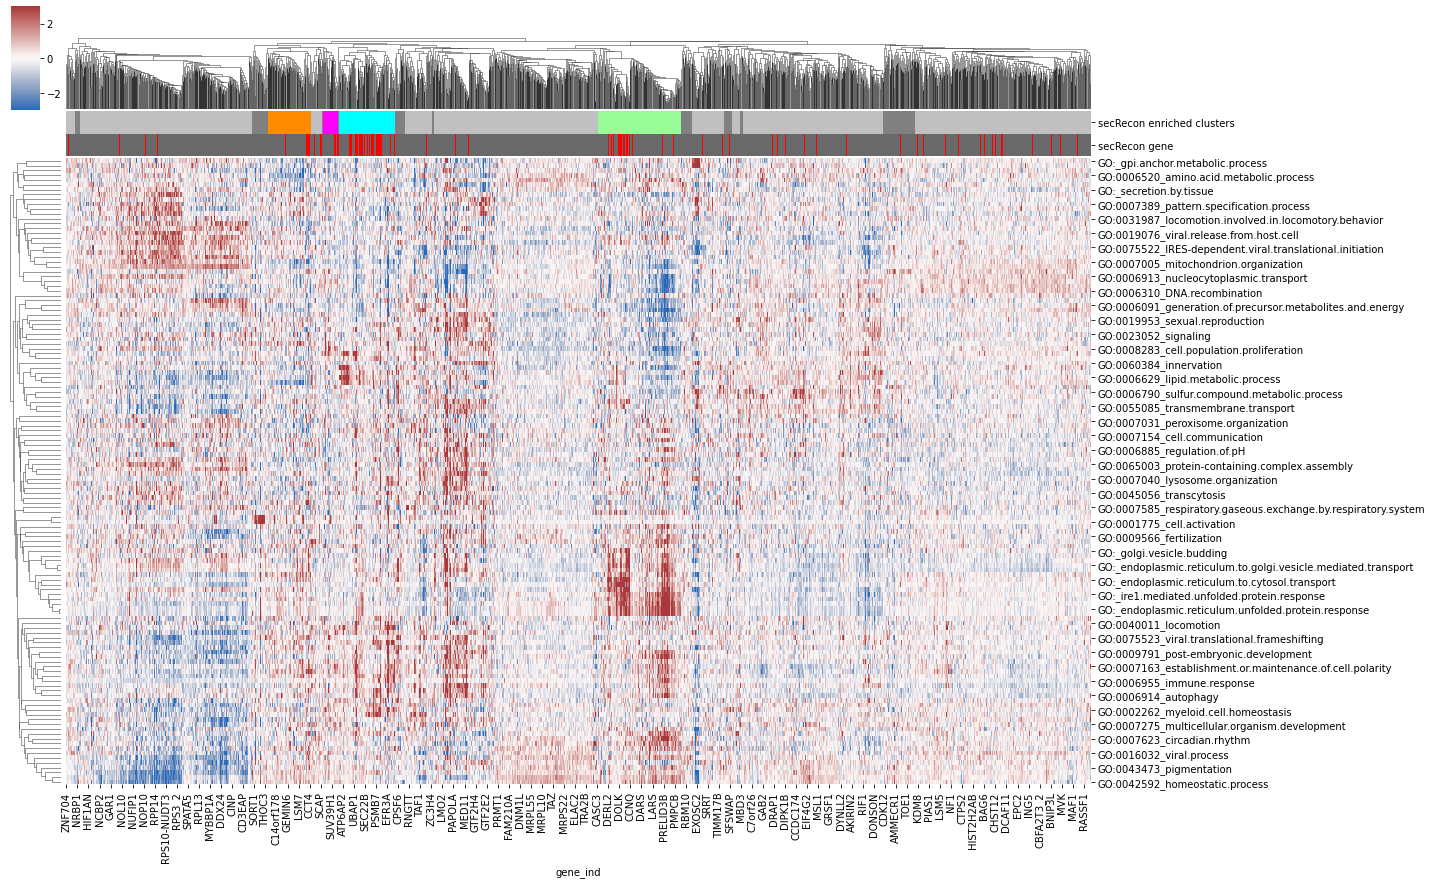

In [414]:
# annotate clustermap with the identified sig. SR clusters
# SR {7: 4, 10: 3, 12: 15, 18: 6}

sr_sig_clusters = [7,10,12,18]

i='k_g'
db='GO'

k_g_clustercol = []
k_g_kmap=ad_strong_viz_dend[i][db+'_perturbation_kclustermaps'][1]
for g in [*k_g_kmap]:
    if k_g_kmap[g] == 7:
        k_g_clustercol.append('darkorange')
    elif k_g_kmap[g] == 10:
        k_g_clustercol.append('magenta')
    elif k_g_kmap[g] == 12:
        k_g_clustercol.append('cyan')
    elif k_g_kmap[g] == 18:
        k_g_clustercol.append('palegreen')
    elif k_g_kmap[g] in ppi_sig_k:
        k_g_clustercol.append('silver')
    else:
        k_g_clustercol.append('grey')
    
k_g_kmap_df = pd.DataFrame(k_g_clustercol, index=[*k_g_kmap], columns=["secRecon enriched clusters"])
k_g_kmap_df['secRecon gene'] = ['red' if i in [*gene_dict] else 'dimgrey' for i in k_g_kmap_df.index.tolist()]

# i_c = clustermap_with_colored_labels(ad_strong_viz[i][db].T, [*gene_dict], color='red',size=(20,12),title=i+' '+db,remove_dend=False)
# clustermap_with_colored_labels(ad_strong_viz[i][db].T, [*gene_dict], color='red',size=(20,12),title=i+' '+db,remove_dend=False)

sns.clustermap(ad_strong_viz[i][db].T,z_score=0,figsize=(20,12),metric='correlation',
               col_colors=k_g_kmap_df,
               cmap='vlag',
               vmin=-3,vmax=3,center=0,dendrogram_ratio=(0.05,0.1),cbar_pos=(0.01, 0.9, 0.02, 0.12))

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


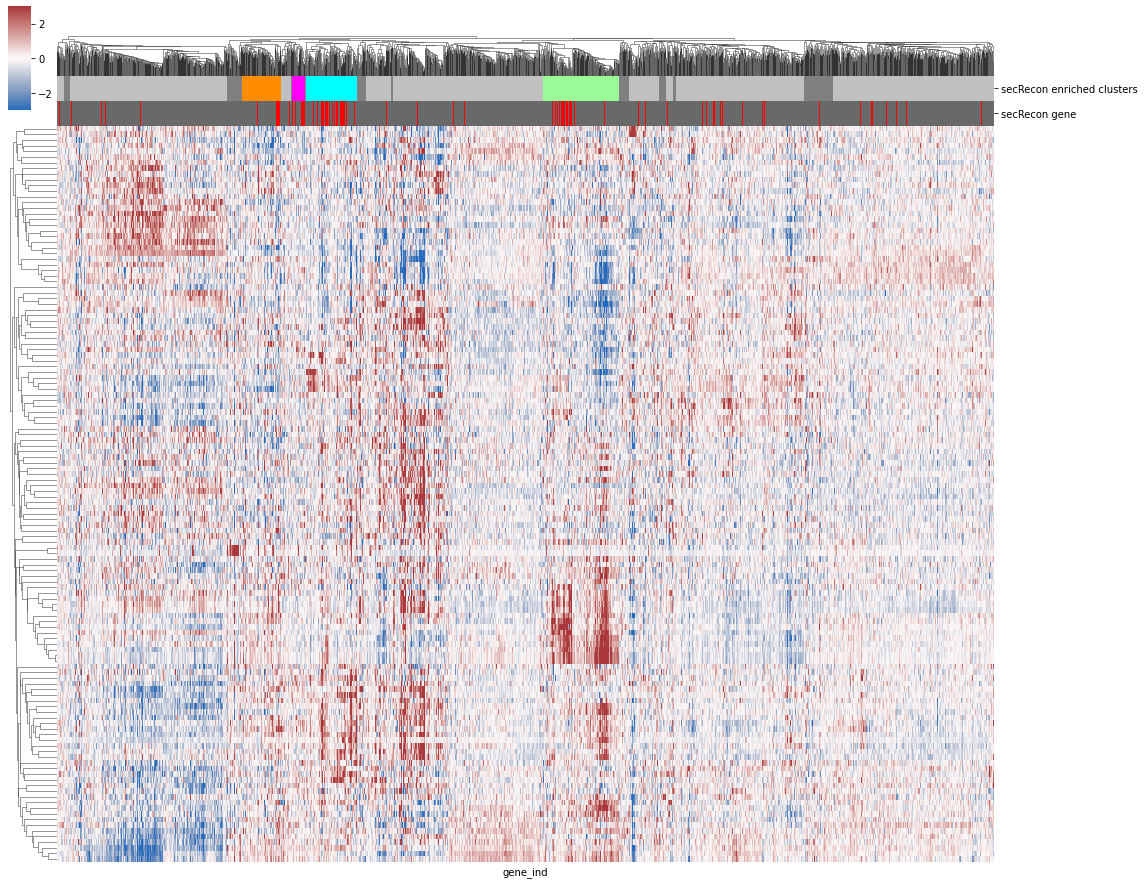

In [558]:
# removing x, y labels
sns.clustermap(ad_strong_viz[i][db].T,z_score=0,figsize=(16,12),metric='correlation',
               col_colors=k_g_kmap_df,
               cmap='vlag',
               vmin=-3,vmax=3,center=0,dendrogram_ratio=(0.05,0.05),cbar_pos=(0.01, 0.9, 0.02, 0.12),
              yticklabels=False,xticklabels=False)

# pairwise correlation of perturbation pairs
expectation: increase mean in pairwise correlation profiles of pathway scores for genes/perturbations with similar function

In [16]:
# execute pairwise spearman correlation of GO-BP-slim pathway scores for strong perturbations

from itertools import combinations

ad_perturb_corr = defaultdict(dict)

for i in [*ad_strong_viz][:1]:
    
    i_df = ad_strong_viz[i]['GO'].T # pd.DataFrame(ad_var[i].X)
#     i_df.index = ad_var[i].obs['gene_ind']

    # Calculate the Spearman correlation matrix
    spearman_corr = i_df.corr(method="spearman")

    # Convert the correlation matrix to a long DataFrame
    # Extract unique pairs using combinations
    pairs = [
        (col1, col2)
        for col1, col2 in combinations(spearman_corr.columns, 2)
    ]
    corr_values = [spearman_corr.loc[pair] for pair in pairs]

    long_df = pd.DataFrame({
        "Pair": pairs,
        "SpearmanCorrelation": corr_values
    })

    # Add a column indicating if both samples in the pair are in the gene list
    long_df["BothInSR"] = long_df["Pair"].apply(
        lambda x: all(gene.split('_')[0] in [*gene_dict] for gene in x)
    )

    # Output the resulting long DataFrame
    ad_perturb_corr[i] = long_df
#     print(long_df)


In [18]:
# obtain specific parent-child secRecon terms for systems enriched in this screen
tp_terms = []

for p in [*ont_c2p]:
    if ont_c2p[p] in ['Translocation','Proteostasis']:
        tp_terms.append(p)
        
for p in [*ont_c2p_2]:
    if ont_c2p_2[p] in ['Translocation','Proteostasis'] or ont_c2p[ont_c2p_2[p]] in ['Translocation','Proteostasis']:
        tp_terms.append(p)
tp_terms = list(set(tp_terms))
len(tp_terms)
tp_terms

['Mislocalized protein degradation',
 'Co-translational translocation',
 'Apoptosis',
 'Ubiquitination',
 'Post-translational translocation',
 'Translocation',
 'Proteostasis',
 'ER stress response/UPR',
 'Retrotranslocation',
 'ER Ca Homeostasis',
 'ERAD',
 'Proteasomal degradation',
 'Autophagy (Proteostasis)',
 'TRC pathway',
 'ATF6 pathway',
 'ERpQC',
 'PERK pathway',
 'IRE1 pathway',
 'Lysosomal degradation/Glyco-conjugate degradation',
 'MAPS']

In [25]:
vizdf=ad_perturb_corr[i]

for k in [7,10,12,18]:
    vizdf['cluster_'+str(k)] = vizdf["Pair"].apply(lambda x: all(gene.split('_')[0] in ad_strong_viz_dend[i]["GO"+'_perturbation_kclustermaps'][0][k] for gene in x))

vizdf['GO:_regulation.of.secretion'] = vizdf["Pair"].apply(lambda x: all(gene.split('_')[0] in goslim['GO:_regulation.of.secretion'] for gene in x))

#### add secrecon term annotations in translocation, proteostasis

vizdf_sr = vizdf[vizdf['BothInSR'] == True].copy()
vizdf.shape, vizdf_sr.shape

((1892485, 8), (12720, 8))

In [28]:
for p in tp_terms:
    vizdf['SR_'+p] = vizdf["Pair"].apply(lambda x: all(gene.split('_')[0] in t2g_dict[p] for gene in x))

In [31]:
# add labels for secrecon terms
for gs in list(set([i for i in ad_strong_cluster_analysis['k_g']['GO_cluster_ora_sig']['Pathway'] if 'GO:' not in i])):
    vizdf_sr[gs] = vizdf_sr["Pair"].apply(lambda x: all(gene.split('_')[0] in t2g_dict[gs] for gene in x))

In [33]:
# remove top and right plot edge outlines
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

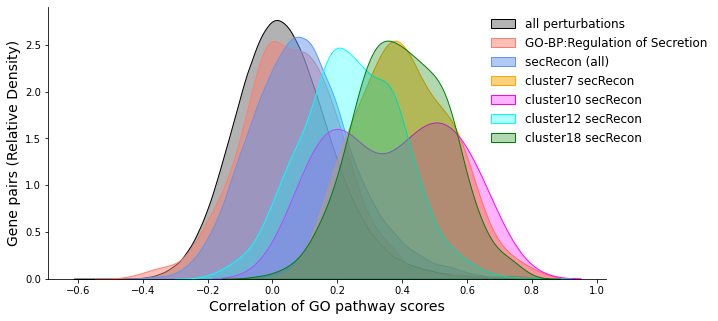

In [38]:
# plot kde distributions of pairwise correlations for perturbation clusters with significant secRecon enrichment
## relative to "null" all perturbation, and wider groups (GO-BP regulation of secretion term as a general, wide geneset)
## and ALL secRecon genes

plt.figure(figsize=(10,5))
ax=sns.kdeplot(vizdf, x='SpearmanCorrelation',fill=True, alpha=0.3,label='all perturbations',color='black')
ax=sns.kdeplot(vizdf[vizdf['GO:_regulation.of.secretion'] == True], x='SpearmanCorrelation',fill=True, alpha=0.5,label='GO-BP:Regulation of Secretion',
           color='salmon')

ax=sns.kdeplot(vizdf_sr, x='SpearmanCorrelation',fill=True, alpha=0.5,label='secRecon (all)',color='cornflowerblue')

ax=sns.kdeplot(vizdf_sr[vizdf_sr['cluster_7'] == True], x='SpearmanCorrelation',fill=True, alpha=0.5,label='cluster7 secRecon',color='orange')
ax=sns.kdeplot(vizdf_sr[vizdf_sr['cluster_10'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='cluster10 secRecon',color='magenta')
ax=sns.kdeplot(vizdf_sr[vizdf_sr['cluster_12'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='cluster12 secRecon',color='cyan')
ax=sns.kdeplot(vizdf_sr[vizdf_sr['cluster_18'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='cluster18 secRecon',color='green')
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0),frameon=False,fontsize=12)
ax.set_xlabel('Correlation of GO pathway scores',fontsize=14)
ax.set_ylabel('Gene pairs (Relative Density)',fontsize=14)
# ax.rc('axes', titlesize=12)     # fontsize of the axes title

# plt.show()
plt.savefig('../kde_cluster_sr.png',dpi=1000,bbox_inches='tight')

/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_82763/2332737883.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(vizdf_sr[vizdf_sr[p] == True], x='SpearmanCorrelation',fill=True, alpha=0.5,label=p)


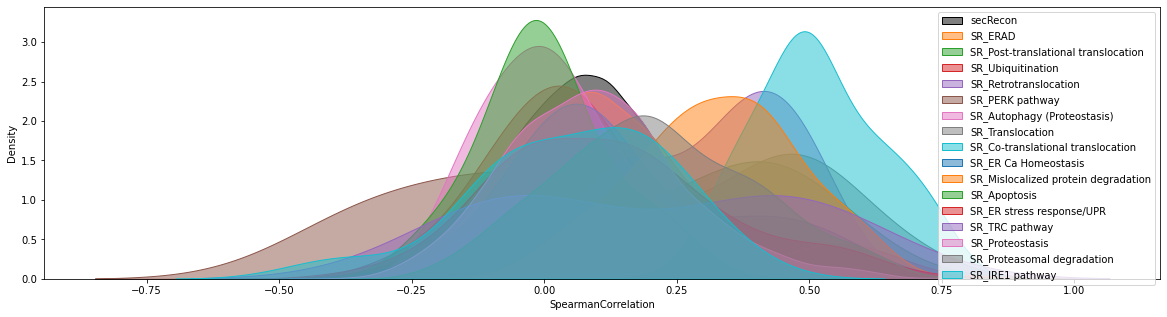

In [474]:
# for parent to child // processes to subsystems
plt.figure(figsize=(20,5))

sns.kdeplot(vizdf_sr, x='SpearmanCorrelation',fill=True, alpha=0.5,label='secRecon',color='cornflowerblue')

for p in vizdf_sr.columns:
    if 'SR_' in p:
        sns.kdeplot(vizdf_sr[vizdf_sr[p] == True], x='SpearmanCorrelation',fill=True, alpha=0.5,label=p)
        
plt.legend()

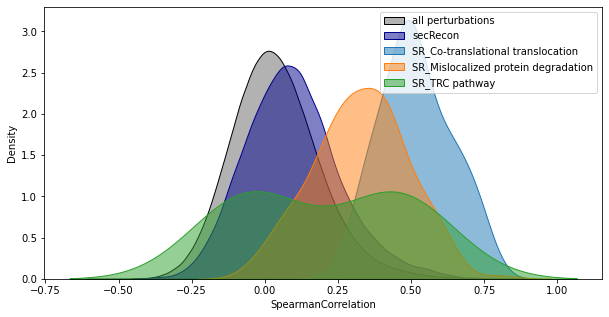

In [479]:
# translocation --> subsytem level trends
plt.figure(figsize=(10,5))

sns.kdeplot(vizdf, x='SpearmanCorrelation',fill=True, alpha=0.3,label='all perturbations',color='black')
sns.kdeplot(vizdf_sr, x='SpearmanCorrelation',fill=True, alpha=0.5,label='secRecon',color='darkblue')

for p in vizdf_sr.columns:
    if 'SR_' in p and p.split('_')[1] in ['Co-translational translocation','Mislocalized protein degradation','TRC pathway']:
        sns.kdeplot(vizdf_sr[vizdf_sr[p] == True], x='SpearmanCorrelation',fill=True, alpha=0.5,label=p)
        
plt.legend()

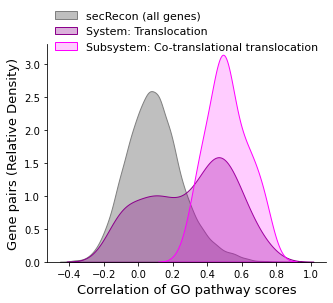

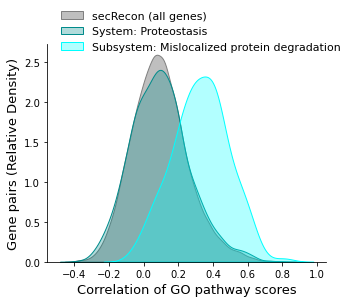

In [42]:
## translocation and proteostasis subsystems

fig = plt.figure(figsize=(5,4))

ax = sns.kdeplot(vizdf_sr, x='SpearmanCorrelation',fill=True, alpha=0.5,label='secRecon (all genes)',color='grey')

ax = sns.kdeplot(vizdf_sr[vizdf_sr['Translocation'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='System: Translocation',color='darkmagenta')
ax = sns.kdeplot(vizdf_sr[vizdf_sr['Co-translational translocation'] == True], x='SpearmanCorrelation',fill=True, alpha=0.2,label='Subsystem: Co-translational translocation',color='magenta')
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),frameon=False,fontsize=11)
ax.set_xlabel('Correlation of GO pathway scores',fontsize=13)
ax.set_ylabel('Gene pairs (Relative Density)',fontsize=13)
# plt.show()
plt.savefig('../kde_translocation.png',dpi=1000,bbox_inches='tight')

fig = plt.figure(figsize=(5,4))

ax = sns.kdeplot(vizdf_sr, x='SpearmanCorrelation',fill=True, alpha=0.5,label='secRecon (all genes)',color='grey')
ax = sns.kdeplot(vizdf_sr[vizdf_sr['Proteostasis'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='System: Proteostasis',color='darkcyan')
ax = sns.kdeplot(vizdf_sr[vizdf_sr['Mislocalized protein degradation'] == True], x='SpearmanCorrelation',fill=True, alpha=0.3,label='Subsystem: Mislocalized protein degradation',color='cyan')
ax.legend(loc='upper center',bbox_to_anchor=(0.55, 1.2),frameon=False,fontsize=11)
ax.set_xlabel('Correlation of GO pathway scores',fontsize=13)
ax.set_ylabel('Gene pairs (Relative Density)',fontsize=13)
# plt.show()
plt.savefig('../kde_proteostasis.png',dpi=1000,bbox_inches='tight')
